In [1]:
# 导入工具包
import time
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 获取计算硬件
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [3]:
#图像预处理
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [4]:
# 数据集文件夹路径
dataset_dir = '../../data/lungImageSet_split'
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'test')
print('训练集路径', train_path)
print('测试集路径', test_path)

from torchvision import datasets
# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)
# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

训练集路径 ../../data/lungImageSet_split/train
测试集路径 ../../data/lungImageSet_split/test
训练集图像数量 12000
类别个数 3
各类别名称 ['lung_aca', 'lung_n', 'lung_scc']
测试集图像数量 3000
类别个数 3
各类别名称 ['lung_aca', 'lung_n', 'lung_scc']


In [5]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
# 映射关系：类别 到 索引号
train_dataset.class_to_idx
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [6]:
idx_to_labels

{0: 'lung_aca', 1: 'lung_n', 2: 'lung_scc'}

In [7]:
#定义数据加载器
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

In [8]:
# 导入训练所需工具包
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

In [9]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [10]:
def evaluate_testset():
    # 在整个测试集上评估，返回分类评估指标日志
    
    # 交叉熵损失函数
    criterion = nn.CrossEntropyLoss() 
    loss_list = []
    labels_list = []
    preds_list = []
    
    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测
            # outputs = outputs.logits
            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)
        
    log_test = {}
    
    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss)
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro')
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro')
    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro')
    
    return log_test

In [11]:
# 载入最佳模型作为当前模型
model = torch.load('./best-1.000.pth')
model.eval()
print(evaluate_testset())

{'test_loss': 7.575038e-05, 'test_accuracy': 1.0, 'test_precision': 1.0, 'test_recall': 1.0, 'test_f1-score': 1.0}


In [12]:
# from torchsummary import summary
# summary(model, input_size=(3, 32, 32),batch_size=256)

In [13]:
# pip install wandb

In [14]:
import torch.nn.utils.prune as prune
# 定义剪枝率
prune_ratio = 0.5

# 完整训练代码：测试不同的比例R，对分类准确率、攻击成功率的影响
R = [0.05,0.075,0.1,0.2,0.3,0.4,0.5,0.515,0.53,0.545,0.56,0.58,0.6,0.7,0.8,0.9]
accuracy_save = []
loss_save = []
precision_save = []
recall_save = []
f1_score_save = []

for i in range(0,len(R)):
    prune_ratio = R[i]
    # 载入最佳模型作为当前模型
    model = torch.load('./best-1.000.pth')
    # 对 ResNet50 的每个卷积层和线性层进行剪枝
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=prune_ratio)
            prune.remove(module, 'weight')  # 移除以恢复原始权重
        elif isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=prune_ratio)
            prune.remove(module, 'weight')  # 移除以恢复原始权重
    model.eval()
    log_test = evaluate_testset()
    accuracy_save.append(log_test['test_accuracy'])
    loss_save.append(log_test['test_loss'])
    precision_save.append(log_test['test_precision'])
    recall_save.append(log_test['test_recall'])
    f1_score_save.append(log_test['test_f1-score'])
    
# # 保存剪枝后的模型
# torch.save(model, 'pruned_resnet50.pth')

# # 评估剪枝后的模型
# model.eval()
# print(evaluate_testset())

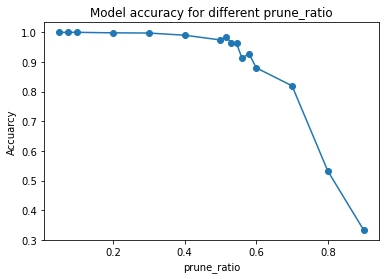

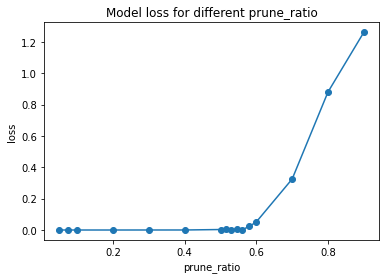

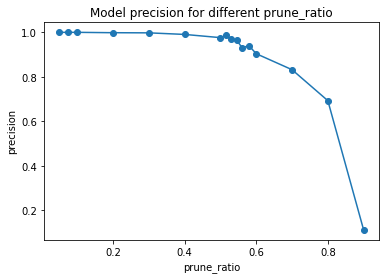

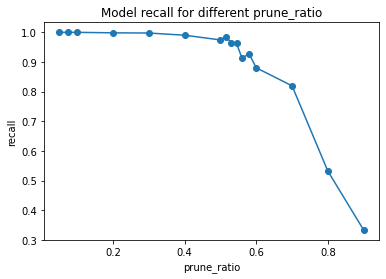

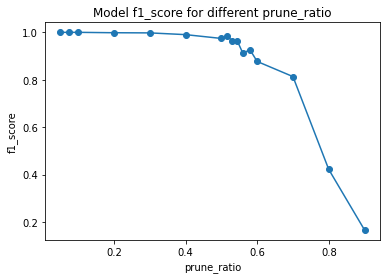

In [15]:
import matplotlib.pyplot as plt
plt.plot(R, accuracy_save, '-o')
plt.title('Model accuracy for different prune_ratio')
plt.ylabel('Accuarcy')
plt.xlabel('prune_ratio')
plt.show()

plt.plot(R, loss_save, '-o')
plt.title('Model loss for different prune_ratio')
plt.ylabel('loss')
plt.xlabel('prune_ratio')
plt.show()

plt.plot(R, precision_save, '-o')
plt.title('Model precision for different prune_ratio')
plt.ylabel('precision')
plt.xlabel('prune_ratio')
plt.show()

plt.plot(R, recall_save, '-o')
plt.title('Model recall for different prune_ratio')
plt.ylabel('recall')
plt.xlabel('prune_ratio')
plt.show()

plt.plot(R, f1_score_save, '-o')
plt.title('Model f1_score for different prune_ratio')
plt.ylabel('f1_score')
plt.xlabel('prune_ratio')
plt.show()

In [16]:
print(accuracy_save)
print(loss_save)
print(precision_save)
print(recall_save)
print(f1_score_save)

[1.0, 1.0, 1.0, 0.9983333333333333, 0.9976666666666667, 0.9903333333333333, 0.9743333333333334, 0.9853333333333333, 0.9653333333333334, 0.9626666666666667, 0.9136666666666666, 0.9273333333333333, 0.8803333333333333, 0.8196666666666667, 0.532, 0.3333333333333333]
[7.5420765e-05, 6.981732e-05, 7.1048555e-05, 5.9685808e-05, 0.00017323195, 0.00021742497, 0.0031757485, 0.006021244, 0.0030844714, 0.0036849945, 0.0019149194, 0.022595167, 0.05196352, 0.32560533, 0.8809403, 1.2620946]
[1.0, 1.0, 1.0, 0.9983416252072969, 0.9976828864614365, 0.9906057661159702, 0.9761683689260291, 0.9859514687100894, 0.9685990338164251, 0.9664268585131893, 0.9314270585120465, 0.9393590682428427, 0.903869815806759, 0.8320145942734257, 0.6926977309538548, 0.1111111111111111]
[1.0, 1.0, 1.0, 0.9983333333333334, 0.9976666666666666, 0.9903333333333334, 0.9743333333333334, 0.9853333333333333, 0.9653333333333333, 0.9626666666666667, 0.9136666666666667, 0.9273333333333333, 0.8803333333333333, 0.8196666666666667, 0.531999

In [19]:
model = torch.load('./best-1.000.pth')
# 对 ResNet50 的每个卷积层和线性层进行剪枝
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.55)
        prune.remove(module, 'weight')  # 移除以恢复原始权重
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.55)
        prune.remove(module, 'weight')  # 移除以恢复原始权重
model.eval()
print(evaluate_testset())

{'test_loss': 0.00500649, 'test_accuracy': 0.9586666666666667, 'test_precision': 0.963226571767497, 'test_recall': 0.9586666666666667, 'test_f1-score': 0.9585071682213094}


In [20]:
# 保存剪枝后的模型
torch.save(model, 'pruned_resnet50.pth')

In [14]:
# pip install torchsummary

In [17]:
# from torchsummary import summary
# summary(model, input_size=(3, 32, 32),batch_size=256)

In [28]:
from torch.optim import lr_scheduler
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 将学习率设置为原来的 1/10

# 训练轮次 Epoch
EPOCHS = 5
batch_idx = 0
# 学习率降低策略
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [29]:
epoch = 0
batch_idx = 0
best_test_accuracy = 0
best_test_loss = 10000

In [30]:
def train_one_batch(images, labels):
    # 运行一个 batch 的训练，返回当前 batch 的训练日志
    
    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images) # 输入模型，执行前向预测
    loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
    
    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标 用于动态监测loss与accuracy
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    # log_train['train_precision'] = precision_score(labels, preds, average='macro')
    # log_train['train_recall'] = recall_score(labels, preds, average='macro')
    # log_train['train_f1-score'] = f1_score(labels, preds, average='macro')
    
    return log_train

In [31]:
# 训练日志-训练集
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log.append(log_train, ignore_index=True)

In [32]:
# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log.append(log_test, ignore_index=True)

In [33]:
# 载入剪枝后的模型作为当前模型
model = torch.load('pruned_resnet50.pth')
model = model.to(device)

# 微调模型
for epoch in range(1, EPOCHS+1):
    
    print(f'Epoch {epoch}/{EPOCHS}')  # 打印当前训练轮数
    
    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader):  # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)  # 一次训练一个batch
        df_train_log = df_train_log.append(log_train, ignore_index=True)
        
    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    print(log_test)
    df_test_log = df_test_log.append(log_test, ignore_index=True)
    
    if log_test['test_accuracy'] >= best_test_accuracy: 
        if log_test['test_loss'] < best_test_loss: 
            # 删除旧的最佳模型文件(如有)
            old_best_checkpoint_path = './fine_tuned_pruned_resnet50-{:.3f}.pth'.format(best_test_accuracy)
            if os.path.exists(old_best_checkpoint_path):
                os.remove(old_best_checkpoint_path)
            # 保存新的最佳模型文件
            new_best_checkpoint_path = './fine_tuned_pruned_resnet50-{:.3f}.pth'.format(log_test['test_accuracy'])
            torch.save(model, new_best_checkpoint_path)
            print('保存新的最佳模型', './fine_tuned_pruned_resnet50-{:.3f}.pth'.format(best_test_accuracy))
            best_test_accuracy = log_test['test_accuracy']
            best_test_loss = log_test['test_loss']

# # 保存微调后的模型
# torch.save(model, 'fine_tuned_pruned_resnet50-{:.3f}.pth')

# # 评估微调后的模型
# model.eval()
# print(evaluate_testset())

Epoch 1/5


100%|██████████| 188/188 [00:38<00:00,  4.92it/s]


{'test_loss': 0.0012905959, 'test_accuracy': 0.9993333333333333, 'test_precision': 0.9993346640053226, 'test_recall': 0.9993333333333334, 'test_f1-score': 0.9993333326666659}
保存新的最佳模型 ./fine_tuned_pruned_resnet50-0.000.pth
Epoch 2/5


100%|██████████| 188/188 [00:38<00:00,  4.93it/s]


{'test_loss': 0.0012217328, 'test_accuracy': 0.9993333333333333, 'test_precision': 0.9993346640053226, 'test_recall': 0.9993333333333334, 'test_f1-score': 0.9993333326666659}
保存新的最佳模型 ./fine_tuned_pruned_resnet50-0.999.pth
Epoch 3/5


100%|██████████| 188/188 [00:38<00:00,  4.91it/s]


{'test_loss': 0.0009464224, 'test_accuracy': 0.9993333333333333, 'test_precision': 0.9993346640053226, 'test_recall': 0.9993333333333334, 'test_f1-score': 0.9993333326666659}
保存新的最佳模型 ./fine_tuned_pruned_resnet50-0.999.pth
Epoch 4/5


100%|██████████| 188/188 [00:38<00:00,  4.94it/s]


{'test_loss': 0.0012235055, 'test_accuracy': 0.9993333333333333, 'test_precision': 0.9993346640053226, 'test_recall': 0.9993333333333334, 'test_f1-score': 0.9993333326666659}
Epoch 5/5


100%|██████████| 188/188 [00:37<00:00,  4.97it/s]


{'test_loss': 0.0014658093, 'test_accuracy': 0.9993333333333333, 'test_precision': 0.9993346640053226, 'test_recall': 0.9993333333333334, 'test_f1-score': 0.9993333326666659}


In [35]:
# 评估微调后的模型
model = torch.load('fine_tuned_pruned_resnet50-0.999.pth')
model.eval()
print(evaluate_testset())

{'test_loss': 0.0009464224, 'test_accuracy': 0.9993333333333333, 'test_precision': 0.9993346640053226, 'test_recall': 0.9993333333333334, 'test_f1-score': 0.9993333326666659}
